# Time-domain impulse response

A comparison between the analytical solution and `empymod` for a time-domain impulse responses for inline, x-directed source and receivers, for the four different frequency-to-time methods **QWE**, **FHT**, **FFTLog**, and **FFT**.

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.constants import mu_0       # Permeability of free space  [H/m]

from empymod import dipole

# Style adjustments
%matplotlib inline
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['text.usetex'] = True
rcParams['font.serif'] = 'Computer Modern Roman'
rcParams['font.family'] = 'serif'
rcParams['font.style'] = 'normal'

## Analytical solutions for source and receiver at the interface between two half-spaces

The time-domain step and impulse responses for a source at the origin ($x_s = y_s = z_s = 0\,$m) and an in-line receiver at the surface ($y_r = z_r = 0\,$m), is given by the following equations, where $\rho$ is resistivity ($\Omega\,$m), $r$ is offset (m), and $t$ is time (s); $\mu_0$ is the magnetic permeability of free space (H/m).

$$
    E_x(\rho,r,t) = \frac{\mu_0^{3/2}}{8 \pi^{3/2} t^{5/2} \rho^{1/2}} \exp\left(-\frac{\mu_0 r^2}{4\rho t}\right)
$$

Reference:  
Wilson, A. J. S., 1997, equation 5.38; The equivalent wavefield concept in multichannel transient electromagnetic surveying; Ph.D., University Of Edinburgh; http://hdl.handle.net/1842/7101.

### Analytical functions

In [2]:
def ee_xx_impulse(res, off, time):
    """Halfspace impulse response, xx, inline.
    
    Wilson, A. J. S., 1997, equation 5.38.
    The equivalent wavefield concept in multichannel transient electromagnetic surveying.
    Ph.D., University Of Edinburgh.
    http://hdl.handle.net/1842/7101

    res   : horizontal resistivity [Ohm.m]
    off   : offset [m]
    time  : time(s) [s]
    """
    return mu_0**1.5/(8*t**2.5*res**0.5*np.pi**1.5)*np.exp(-mu_0*off**2/(4*res*time))

## Example 1: Source and receiver at z=0m

Comparison with analytical solution; put 1 mm below the interface, as they would be regarded as in the air by `emmod` otherwise.

In [3]:
src = [0, 0, 0.001]          # Source at origin, slightly below interface
rec = [6000, 0, 0.001]       # Receivers in-line, 0.5m below interface
res = [1e23, 10]             # Resistivity: [air, half-space]
signal = 0                   # Impulse response
t = np.logspace(-2, 2, 101)  # Desired times (s)
inparg = {'src': src, 'rec': rec, 'depth': 0, 'freqtime': t, 'res': res,
          'signal': signal, 'ht': 'fht', 'verb': 1}

### Impulse response

In [4]:
ex = ee_xx_impulse(res[1], rec[0], t)

In [5]:
inparg['signal'] = 0 # signal 0 = impulse
qwe = dipole(**inparg, ft='qwe')
sin = dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
ftl = dipole(**inparg, ft='fftlog')
fft = dipole(**inparg, ft='fft', ftarg=[.00005, 2**20, '', 10])

* WARNING :: Fourier-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.


=> `FFTLog` is the fastest by quite a margin, followed by the `Sine`-filter. What cannot see from the output (set `verb` to something bigger than 2 to see it) is how many frequencies each method used:

    - QWE: 7.94328E-05 - 63095.7 Hz : 178
    - Sine:  5.33905E-07 - 57351.4 Hz : 128
    - FFTLog: 1.78575E-05 - 141.847 Hz : 70
    - FFT: 5E-05 - 52.4288 Hz : 61
    
Note that for the actual transform, `FFT` used 2^20 = 1'048'576 frequencies! It only calculated 60 frequencies, and then interpolated the rest, as it requires regularly spaced data.

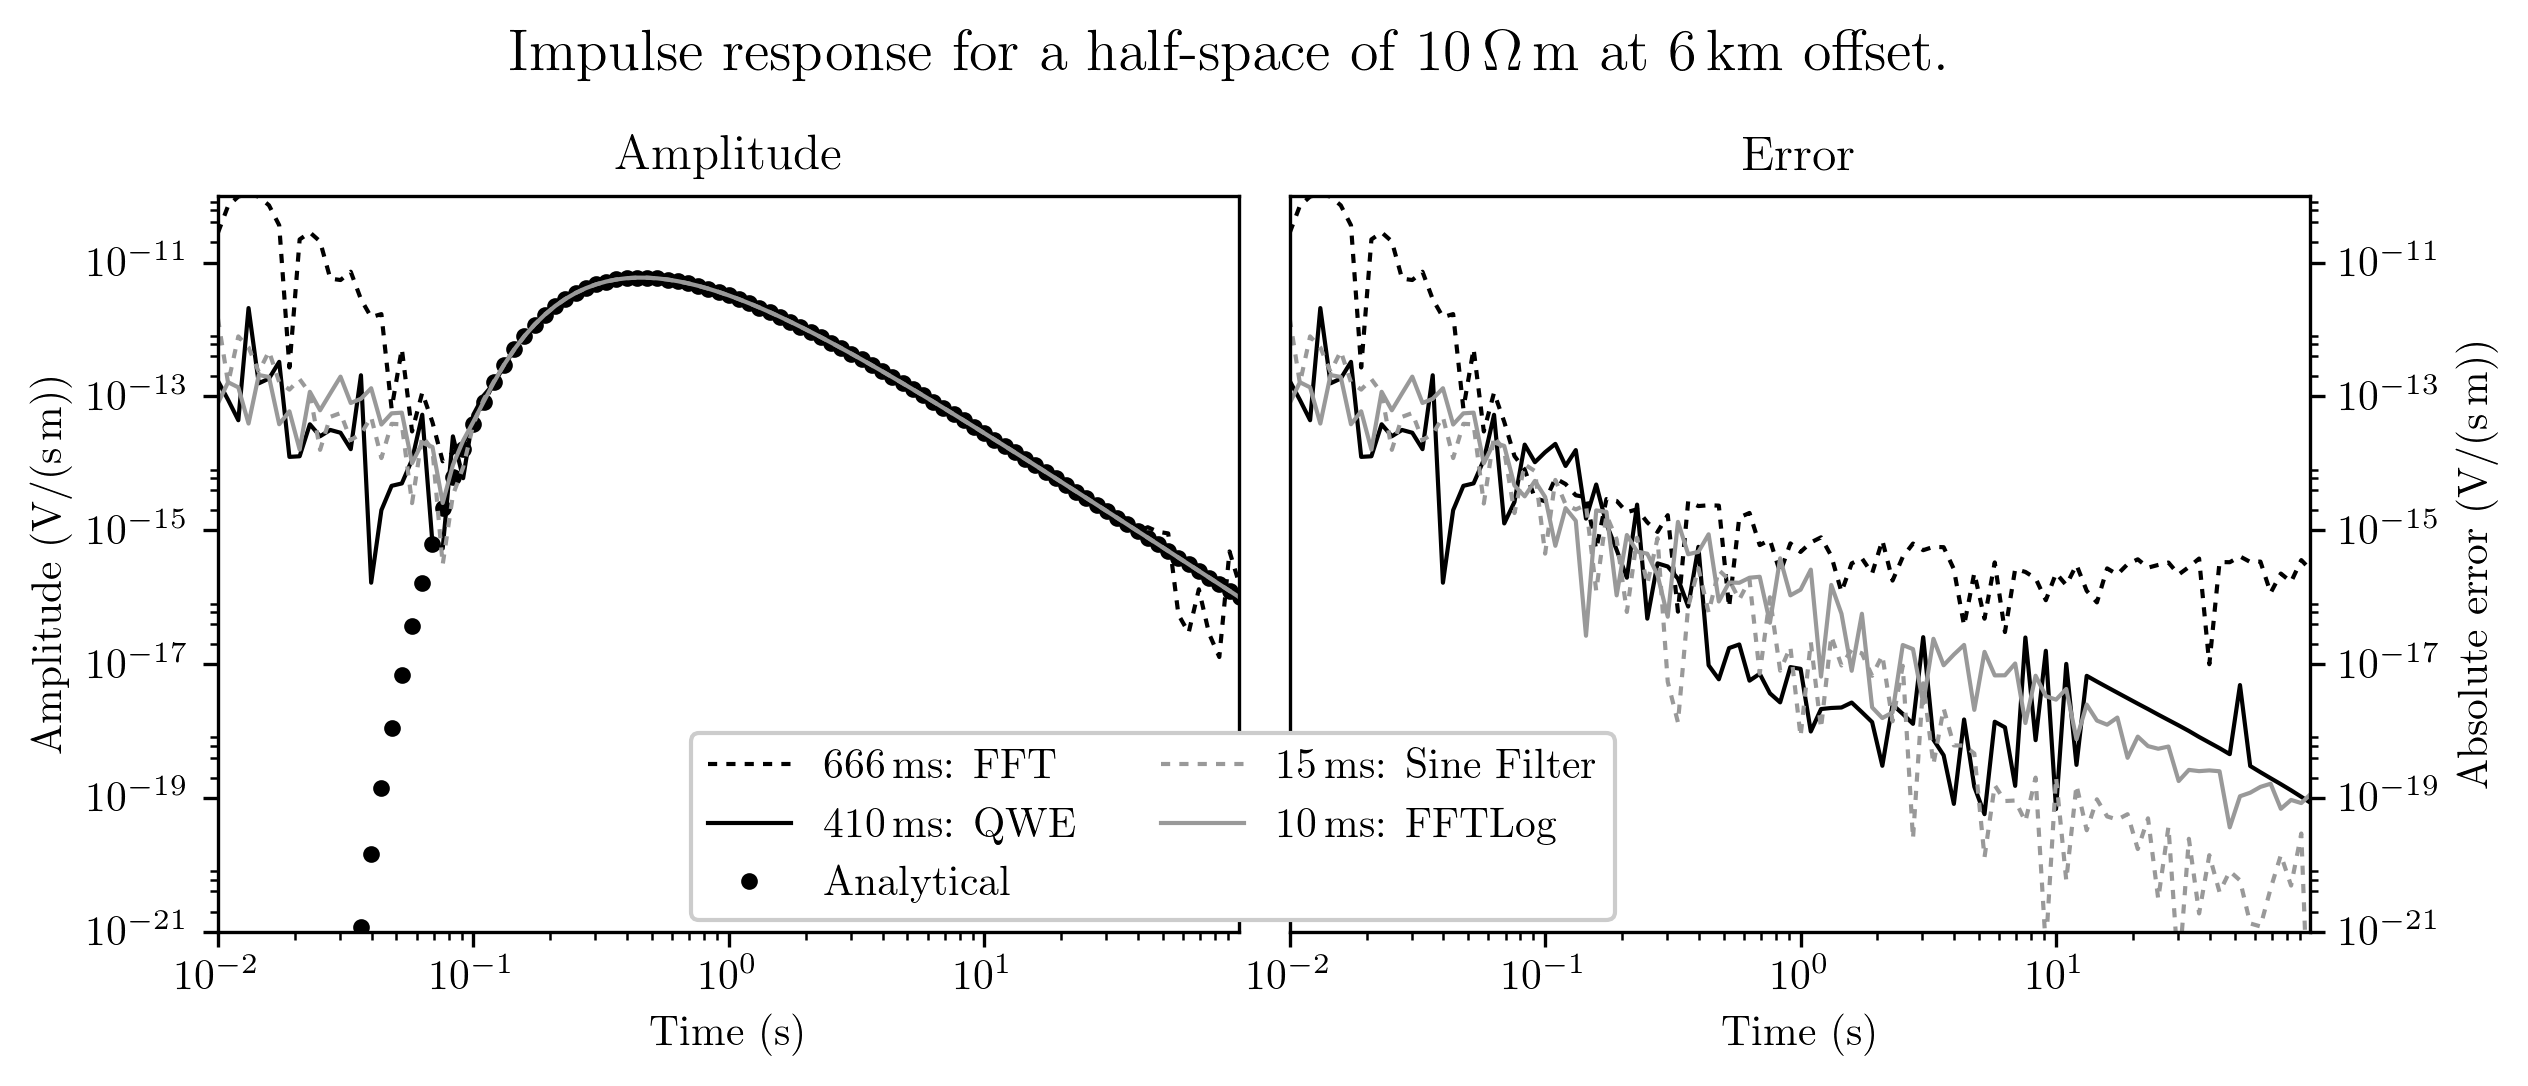

In [6]:
fig, axs = plt.subplots(figsize=(9, 3.25), facecolor = 'w', nrows=1, ncols=2, sharey=True)
fig.subplots_adjust(wspace=.05)
plt.suptitle('Impulse response for a half-space of 10$\,\Omega$\,m at 6\,km offset.', y=1.05, fontsize=14)

# Amplitude
plt.sca(axs[0])
plt.title(r'Amplitude')
plt.xlabel('Time (s)')
plt.ylabel(r'Amplitude (V/(s\,m))')
plt.loglog(t, ex, 'k.', label='Analytical')
plt.loglog(t, np.abs(fft), '0.0', ls=':', lw=1)
plt.loglog(t, np.abs(qwe), '0.0', ls='-', lw=1)
plt.loglog(t, np.abs(sin), '0.6', ls=':', lw=1)
plt.loglog(t, np.abs(ftl), '0.6', ls='-', lw=1)
plt.ylim([1e-21, 1e-10])
plt.xlim([t.min(), t.max()-1])  # Only to 99 to hide 10^2-label

# Error
plt.sca(axs[1])
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Absolute error (V/(s\,m))')
plt.loglog(t, abs(fft-ex), '0.0', ls=':', lw=1, label='666\,ms: FFT')
plt.loglog(t, abs(qwe-ex), '0.0', ls='-', lw=1, label='410\,ms: QWE')
plt.loglog(1e-10, 1e-15, 'k.', label='Analytical')  # Dummy for legend
plt.loglog(t, abs(sin-ex), '0.6', ls=':', lw=1, label='15\,ms: Sine Filter')
plt.loglog(t, abs(ftl-ex), '0.6', ls='-', lw=1, label='10\,ms: FFTLog')
plt.xlim([t.min(), t.max()-1])  # Only to 99 to hide 10^2-label
axs[1].yaxis.set_ticks_position('right')
axs[1].yaxis.set_label_position('right')

# Plot legend
plt.legend(ncol=2, framealpha=1, bbox_to_anchor=(.65, 0.35), bbox_transform=plt.gcf().transFigure)

# Save and show plot
plt.savefig('../figures/impulse.jpg', bbox_inches='tight')
plt.show()

=> The error is comparable in all cases. `FFT` is worse at early and at late times. This could be improved by calculating lower and higher frequencies. But because FFT needs regularly spaced data, our vector would soon explode (and you would need a lot of memory). In the current case we are already using 2^20 samples!

### Timing

In [7]:
print('QWE')
%timeit dipole(**inparg, ft='qwe')
print('Sine filter')
%timeit dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
%timeit dipole(**inparg, ft='fftlog')
print('FFT')
%timeit dipole(**inparg, ft='fft', ftarg=[.00005, 2**20, '', 10])

QWE
1 loop, best of 3: 410 ms per loop
Sine filter
100 loops, best of 3: 15 ms per loop
FFTLog
100 loops, best of 3: 9.45 ms per loop
FFT
1 loop, best of 3: 666 ms per loop
